# DMRG Sweeping method for training TN
***Anomaly detection with SMPO trained using DMRG Sweeping method***

In [1]:
import jax.numpy as jnp
import quimb.tensor as qtn
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *
import matplotlib.pyplot as plt

from tn4ml.initializers import *
from tn4ml.models.smpo import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.loss import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/emapuljak/miniforge3/envs/workspace/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


### Load dataset

In [2]:
train, test = mnist.load_data()
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

In [3]:
normal_class = 0

In [4]:
# training data
X = {
"normal": data["X"]["train"][data["y"]["train"] == normal_class],
"anomaly": data["X"]["train"][data["y"]["train"] != normal_class],
}
# y = {"normal": [0]*len(X["normal"]), "anomaly": [1]*len(X["anomaly"])}

In [5]:
# test data
X_test = {
"normal": data["X"]["test"][data["y"]["test"] == normal_class],
"anomaly": data["X"]["test"][data["y"]["test"] != normal_class],
}
# y_test = {"normal": [0]*len(X_test["normal"]), "anomaly": [1]*len(X_test["anomaly"])}

In [6]:
# reduce size of images for faster training and reduce to 0-1 range
strides = (4,4) # (2,2) for 14x14 images; (4,4) for 7x7 images
pool_size = (2,2)
pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding="same")

# normal
X_pool_normal = pool(tf.constant(X["normal"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7)/255.0
X_pool_normal_test = pool(tf.constant(X_test["normal"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7)/255.0

# anomaly
X_pool_anomaly = pool(tf.constant(X["anomaly"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7)/255.0
X_pool_anomaly_test = pool(tf.constant(X_test["anomaly"].reshape(-1,28,28,1))).numpy().reshape(-1,7,7)/255.0

In [7]:
# rearagne pixels in zig-zag order (from https://arxiv.org/pdf/1605.05775.pdf)

def zigzag_order(data):
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [8]:
train_normal = zigzag_order(X_pool_normal)
test_normal = zigzag_order(X_pool_normal_test)

train_anomaly = zigzag_order(X_pool_anomaly)
test_anomaly = zigzag_order(X_pool_anomaly_test)

In [9]:
# take train_size samples from normal class for training
train_size = 1024

indices = list(range(len(train_normal)))
np.random.shuffle(indices)

indices = indices[:train_size]
train_normal = np.take(train_normal, indices, axis=0)

### Training setup
- direct gradient descent
- optax optimizer
- shape_method = 'even'

In [10]:
# define model parameters
L = 49
#initializer = gramschmidt_init('normal', scale=1e-1)
initializer = identity_init('bond', 1e-1)
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 10
phys_dim = (2, 2)
spacing = 10

In [11]:
model = SMPO_initialize(L=L,
                        initializer=initializer,
                        key=key,
                        shape_method=shape_method,
                        spacing=spacing,
                        bond_dim=bond_dim,
                        phys_dim=phys_dim,
                        cyclic=False)

In [12]:
# new = model.copy_model()

In [13]:
# model.strategy.prehook(model, (0,1))

In [14]:
model

SpacedMatrixProductOperator(tensors=49, indices=102, L=49, max_bond=10)

In [15]:
# define training parameters
optimizer = optax.adam
strategy = 'sweeps'
loss = error_logquad
train_type = 'unsupervised'
embedding = original_inverse(p=2)
#embedding = trigonometric()
learning_rate = 1e-3

model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [16]:
epochs = 5
batch_size = 64

In [17]:
history = model.train(train_normal,
            epochs=epochs,
            batch_size=batch_size,
            embedding = embedding,
            normalize=True,
            dtype=jnp.float64,
            cache=False)


epoch: 100%|██████████| 5/5 [07:02<00:00, 84.55s/it, loss=3753.552997016227, val_loss=None] 


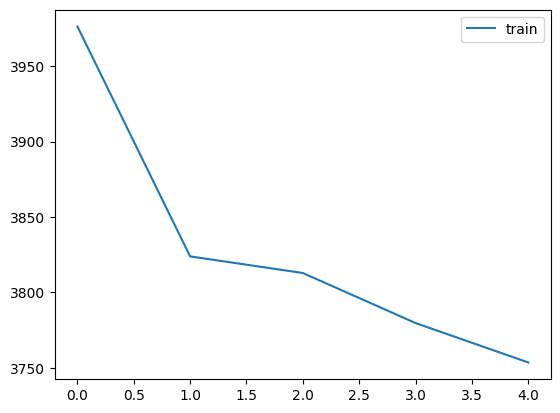

In [18]:
# plot loss
plt.plot(range(len(history['loss'])), history['loss'], label='train')
plt.legend()
plt.show()

### Evaluate

In [19]:
from sklearn.metrics import roc_curve, auc

In [20]:
normal_score = []
anomaly_score = []

anomaly_score = model.evaluate(test_anomaly, evaluate_type='unsupervised', return_list=True, dtype=jnp.float64)
normal_score = model.evaluate(test_normal, evaluate_type='unsupervised', return_list=True, dtype=jnp.float64)

(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


TypeError: iteration over a 0-d array

In [ ]:
def get_roc_data(normal, anomaly):
    true_val = np.concatenate((np.ones(anomaly.shape[0]), np.zeros(normal.shape[0])))
    pred_val = np.concatenate((anomaly, normal))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
    return fpr_loss, tpr_loss

In [ ]:
fpr, tpr = get_roc_data(normal_score, anomaly_score)
auc_value = auc(fpr, tpr)

### Plot anomaly scores and ROC curve

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
plt.hist(anomaly_score, bins=100, histtype='step', label='anomaly')
plt.hist(normal_score, bins=100, histtype='step', label='normal')
plt.title('Anomaly score distribution')
plt.legend()
plt.text(0.5, -0.1, f'AUC Value: {auc_value}', ha='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
